# LeNet-5 手写数字识别 (PyTorch + TensorBoard)

In [1]:
# Imports
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter


In [2]:
# === 全局超参数与配置 ===
# 训练参数
BATCH_SIZE = 64          # 批大小
LEARNING_RATE = 0.01     # 初始学习率
MOMENTUM = 0.9           # 优化器动量
EPOCHS = 5               # 训练总轮数
LOG_INTERVAL = 100       # 训练日志打印频率 (多少个 batch 打印一次)

# 设备配置
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"当前运行设备: {DEVICE}")

# 随机种子 (便于复现)
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

当前运行设备: cuda


## 计算公式与关键参数速览（LeNet-5 相关）
- 卷积输出尺寸（单维度，高或宽相同计算）
  - 公式：$H_{out} = \left\lfloor \frac{H_{in} + 2P - D\cdot(K-1) - 1}{S} + 1 \right\rfloor$
  - 符号：$K$=kernel_size，$S$=stride，$P$=padding，$D$=dilation。
- 池化输出尺寸（平均/最大池化同理）
  - 公式：$H_{out} = \left\lfloor \frac{H_{in} + 2P - (K-1) - 1}{S} + 1 \right\rfloor$
- Conv2d 关键参数（PyTorch）
  - `in_channels`：输入通道数（灰度图为1，RGB为3）
  - `out_channels`：卷积核个数（输出通道数）
  - `kernel_size`：卷积核大小（如 5 或 (5,5)）
  - `stride`：步幅，默认1
  - `padding`：边缘补零，默认0
  - `dilation`：空洞率，默认1
  - `groups`：分组卷积，默认1（常用全通）
  - `bias`：是否带偏置，默认True
  - `padding_mode`：'zeros'（默认）、'reflect' 等
- AvgPool2d 关键参数
  - `kernel_size`、`stride`、`padding`：与卷积同名参数含义一致（一般 stride=kernel_size）
  - `ceil_mode`：是否向上取整输出尺寸，默认False
  - `count_include_pad`：计算平均时是否计入 padding 的0，默认False
- Linear（全连接）关键参数
  - `in_features`：输入特征维度
  - `out_features`：输出特征维度
  - `bias`：是否带偏置
- 参数量（Parameter Count）估算
  - Conv2d：$\text{params} = C_{out} \times \left(\frac{C_{in}}{\text{groups}} \times K_h \times K_w\right) + (\text{bias? } C_{out}:0)$
  - Linear：$\text{params} = \text{in\_features} \times \text{out\_features} + (\text{bias? } \text{out\_features}:0)$
- 激活函数 Tanh
  - 公式：$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$，输出范围(-1,1)
- 交叉熵损失 CrossEntropyLoss（训练单元使用）


In [3]:
# 定义 LeNet-5（基于经典结构的 PyTorch 实现）
# 说明：
# - LeNet-5 是早期的经典卷积网络结构，适合 MNIST 这类小型手写数字识别任务。
# - 本实现严格显式填写每个层的所有关键参数，帮助你理解每个参数的作用。
# - 输入尺寸采用 32×32：我们在数据预处理里对 28×28 的 MNIST 图像进行了 Pad(2)，方便复现原论文的维度。
# - 张量形状约定为 NCHW：N=批大小，C=通道，H=高度，W=宽度。
#

class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5,
                      stride=1, dilation=1, groups=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2,
                         ceil_mode=False, count_include_pad=False),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,
                      stride=1, dilation=1, groups=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2,
                         ceil_mode=False, count_include_pad=False),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5,
                      stride=1, dilation=1, groups=1),
            nn.Tanh()
        )
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84), #全连接层
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes)
            # 未加Softmax, 训练用 CrossEntropyLoss 会内部处理
        )

    def forward(self, x):
        # x 形状：N×1×32×32
        x = self.features(x)   # 经过卷积/池化后：N×120×1×1
        x = x.view(x.size(0), -1)  # 展平为：N×120（保留批维度N，合并其余维度）
        x = self.classifier(x)  # 全连接分类：N×10（每个类别一个logit）
        return x

# 测试模型构建与结构打印（便于确认各层参数与输出形状）
model = LeNet5()
print(model)


LeNet5(
  (features): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [4]:
# 数据准备：MNIST (训练/测试)，使用现有的 ./MNIST 数据并禁用下载；将 28x28 pad 到 32x32 以匹配 LeNet 原始设置
# 使用全局超参数 BATCH_SIZE

transform = transforms.Compose([
    transforms.Pad(2),
    # ToTensor：PIL Image -> Tensor，且把像素值从 [0,255] 映射到 [0.0,1.0]
    transforms.ToTensor()#,
    #transforms.Normalize((0.1307,), (0.3081,))
])

# root 指向当前目录 '.'，torchvision 会在 './MNIST' 下查找 raw/processed
train_dataset = datasets.MNIST(root='.', train=True, download=False, transform=transform)
test_dataset = datasets.MNIST(root='.', train=False, download=False, transform=transform)

# 使用全局 BATCH_SIZE
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print('Train samples:', len(train_dataset), 'Test samples:', len(test_dataset))

Train samples: 60000 Test samples: 10000


In [5]:
# 训练与验证函数（精简版：仅保留核心 Loss/Acc 记录）
def train(model, device, train_loader, optimizer, criterion, epoch, writer, log_interval=LOG_INTERVAL):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

        # 修改：在每个 epoch 的第一个 batch 也进行记录，确保 TensorBoard 能立即看到数据点
        if batch_idx == 0 or (batch_idx + 1) % log_interval == 0:
            # 如果是第一个 batch，分母为 1；否则为 log_interval
            current_interval = 1 if batch_idx == 0 else log_interval
            avg_loss = running_loss / current_interval
            acc = 100. * correct / total
            
            global_step = epoch * len(train_loader) + batch_idx
            # [TensorBoard] 记录训练集平均损失 (Loss)
            writer.add_scalar('metrics/train/loss', avg_loss, global_step)
            # [TensorBoard] 记录训练集准确率 (Accuracy)
            writer.add_scalar('metrics/train/accuracy', acc, global_step)
            
            print(f'Epoch: {epoch} [{batch_idx+1}/{len(train_loader)}]  Loss: {avg_loss:.4f}  Acc: {acc:.2f}%')
            
            # 重置统计变量
            running_loss = 0.0
            correct = 0
            total = 0
            
            # 强制刷新写入，确保数据立即写入磁盘
            writer.flush()

def test(model, device, test_loader, criterion, epoch, writer):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.size(0)
            _, predicted = output.max(1)
            correct += predicted.eq(target).sum().item()
            
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n')
    
    # [TensorBoard] 记录测试集 Loss
    writer.add_scalar('metrics/test/loss', test_loss, epoch)
    # [TensorBoard] 记录测试集 Accuracy
    writer.add_scalar('metrics/test/accuracy', acc, epoch)
    
    writer.flush()
    return test_loss, acc

In [6]:
# 自动启动 TensorBoard 并打开浏览器（在训练前执行）
# 包含清理旧进程和旧日志的逻辑，确保“只看这一次”
import os
import shutil
import subprocess
import time
import webbrowser
from tensorboard import program

# 1. 定义日志目录 (绝对路径)
tb_logdir = os.path.join(os.getcwd(), 'runs', 'lenet_mnist')
print(f"TensorBoard 监控目录: {tb_logdir}")

# 2. 尝试关闭占用端口 6006 的 TensorBoard 进程 (Windows)
# 这样可以释放对日志文件的锁定，允许我们清空目录
print("正在检查端口 6006...")
try:
    # 查找端口占用
    # netstat 输出示例: "  TCP    127.0.0.1:6006         0.0.0.0:0              LISTENING       1234"
    result = subprocess.check_output('netstat -ano | findstr :6006', shell=True).decode()
    if result:
        print("发现旧 TensorBoard 进程，正在终止...")
        pids = set()
        for line in result.strip().split('\n'):
            parts = line.split()
            if len(parts) >= 5:
                pid = parts[-1]
                pids.add(pid)
        
        for pid in pids:
            subprocess.run(f'taskkill /F /PID {pid}', shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        
        time.sleep(2) # 等待系统释放资源
        print("旧 TensorBoard 已关闭。")
except subprocess.CalledProcessError:
    # findstr 返回非 0 表示没找到，即没有进程在运行
    print("端口 6006 未被占用。")
except Exception as e:
    print(f"尝试关闭进程时出错 (可忽略): {e}")

# 3. 清空日志目录 (确保无历史曲线)
if os.path.exists(tb_logdir):
    try:
        shutil.rmtree(tb_logdir)
        print("已清空历史日志目录。")
    except Exception as e:
        print(f"警告: 无法完全清空目录: {e}")

os.makedirs(tb_logdir, exist_ok=True)

# 4. 启动 TensorBoard
tb = program.TensorBoard()
# --reload_interval 1: 设置后端每 1 秒去读取一次磁盘数据（默认通常是 5 秒）
# 这能让数据更新更及时，但前端页面仍需开启自动刷新
tb.configure(argv=[None, '--logdir', tb_logdir, '--port', '6006', '--host', '127.0.0.1', '--reload_interval', '1'])
url = tb.launch()
print(f"TensorBoard 新会话启动成功: {url}")
print("-" * 50)
print("【重要提示】如何实现实时动态更新：")
print("1. TensorBoard 网页右上角通常有一个 '设置' (齿轮图标) 或 'Reload' 按钮。")
print("2. 请确保勾选 'Reload data' (自动刷新数据)。")
print("3. 默认刷新间隔可能是 30s，你可以手动点击刷新按钮来立即查看最新曲线。")
print("-" * 50)

# 打开浏览器
webbrowser.open(url)

TensorBoard 监控目录: d:\ProgrammingWorkplace\basePython\PyTorch_Learning\MNIST_handwriting\runs\lenet_mnist
正在检查端口 6006...
端口 6006 未被占用。
已清空历史日志目录。
TensorBoard 新会话启动成功: http://127.0.0.1:6006/
--------------------------------------------------
【重要提示】如何实现实时动态更新：
1. TensorBoard 网页右上角通常有一个 '设置' (齿轮图标) 或 'Reload' 按钮。
2. 请确保勾选 'Reload data' (自动刷新数据)。
3. 默认刷新间隔可能是 30s，你可以手动点击刷新按钮来立即查看最新曲线。
--------------------------------------------------
TensorBoard 新会话启动成功: http://127.0.0.1:6006/
--------------------------------------------------
【重要提示】如何实现实时动态更新：
1. TensorBoard 网页右上角通常有一个 '设置' (齿轮图标) 或 'Reload' 按钮。
2. 请确保勾选 'Reload data' (自动刷新数据)。
3. 默认刷新间隔可能是 30s，你可以手动点击刷新按钮来立即查看最新曲线。
--------------------------------------------------


True

In [7]:
# 主运行：模型、优化器和训练循环
# 注意：若要清空 TensorBoard 历史曲线，请重新运行上一个“启动 TensorBoard”的单元格

# 使用全局 DEVICE
model = LeNet5().to(DEVICE)
# 使用全局 LEARNING_RATE, MOMENTUM
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.CrossEntropyLoss()

# 使用绝对路径，确保与 TensorBoard 监控的是同一个位置
logdir = os.path.join(os.getcwd(), 'runs', 'lenet_mnist')
print(f"训练日志将写入: {logdir}")

# 确保目录存在
os.makedirs(logdir, exist_ok=True)

writer = SummaryWriter(logdir)

start_epoch = 1
# 使用全局 EPOCHS
for epoch in range(start_epoch, start_epoch + EPOCHS):
    t0 = time.time()
    # 传入全局 DEVICE
    train(model, DEVICE, train_loader, optimizer, criterion, epoch, writer)
    test(model, DEVICE, test_loader, criterion, epoch, writer)
    print(f'Epoch {epoch} finished in {time.time() - t0:.1f}s')

# 保存模型
model_path = './lenet_mnist.pth'
torch.save(model.state_dict(), model_path)
print('Model saved to', model_path)
writer.close()

训练日志将写入: d:\ProgrammingWorkplace\basePython\PyTorch_Learning\MNIST_handwriting\runs\lenet_mnist
Epoch: 1 [1/938]  Loss: 2.3016  Acc: 14.06%
Epoch: 1 [1/938]  Loss: 2.3016  Acc: 14.06%
Epoch: 1 [100/938]  Loss: 2.0966  Acc: 32.69%
Epoch: 1 [100/938]  Loss: 2.0966  Acc: 32.69%
Epoch: 1 [200/938]  Loss: 0.7779  Acc: 78.39%
Epoch: 1 [200/938]  Loss: 0.7779  Acc: 78.39%
Epoch: 1 [300/938]  Loss: 0.4271  Acc: 87.59%
Epoch: 1 [300/938]  Loss: 0.4271  Acc: 87.59%
Epoch: 1 [400/938]  Loss: 0.3388  Acc: 90.50%
Epoch: 1 [400/938]  Loss: 0.3388  Acc: 90.50%
Epoch: 1 [500/938]  Loss: 0.3099  Acc: 91.02%
Epoch: 1 [500/938]  Loss: 0.3099  Acc: 91.02%
Epoch: 1 [600/938]  Loss: 0.2430  Acc: 93.08%
Epoch: 1 [600/938]  Loss: 0.2430  Acc: 93.08%
Epoch: 1 [700/938]  Loss: 0.2303  Acc: 93.30%
Epoch: 1 [700/938]  Loss: 0.2303  Acc: 93.30%
Epoch: 1 [800/938]  Loss: 0.2098  Acc: 93.83%
Epoch: 1 [800/938]  Loss: 0.2098  Acc: 93.83%
Epoch: 1 [900/938]  Loss: 0.1980  Acc: 93.75%
Epoch: 1 [900/938]  Loss: 0.1980  

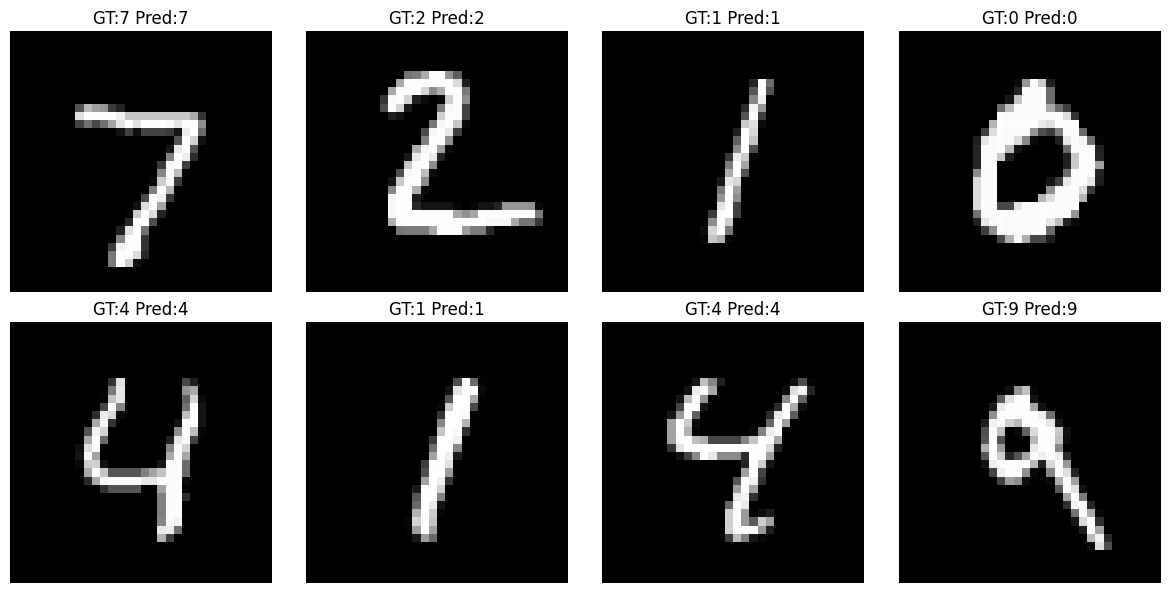

In [8]:
# 示例：加载保存的模型并可视化若干预测结果
# 加载模型
model = LeNet5()
model.load_state_dict(torch.load('./lenet_mnist.pth', map_location='cpu'))
model.eval()

# 取几张测试图像并预测
examples = []
labels = []
with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        if i >= 1:
            break
        outputs = model(data)
        preds = outputs.argmax(dim=1).numpy()
        for j in range(min(8, data.size(0))):
            img = data[j].squeeze().numpy()
            examples.append(img)
            labels.append((int(target[j].item()), int(preds[j].item())))

# 绘制
plt.figure(figsize=(12, 6))
for idx, img in enumerate(examples):
    plt.subplot(2, 4, idx+1)
    plt.imshow(img, cmap='gray')
    gt, pr = labels[idx]
    plt.title(f'GT:{gt} Pred:{pr}')
    plt.axis('off')
plt.tight_layout()
plt.show()

## 本地手写窗口（Tkinter）

- 运行下一个单元将打开一个本地窗口。
- 操作：按住左键在白板上书写；点击“识别”进行推断；“清空”重置画布；“退出”关闭窗口。
- 说明：此窗口使用 Tkinter（Windows 通常自带）。若环境未安装 Tk 支持，可能无法启动。

In [9]:
# 本地手写窗口：Tkinter 画布 + LeNet-5 推理
import os
import numpy as np
from PIL import Image, ImageDraw
import torch
import torch.nn as nn
import torch.nn.functional as F

# Tkinter 可能在某些环境不可用
try:
    import tkinter as tk
except Exception as e:
    print("未能导入 Tkinter：", e)
    raise

# 复用已定义的 LeNet5，如果此单元单独运行则做一次定义
try:
    LeNet5
except NameError:
    print("警告：LeNet-5 模型未定义")

# 加载模型（CPU 推理）
_device = torch.device('cpu')
_model = LeNet5().to(_device)
weights_path = './lenet_mnist.pth'
if os.path.exists(weights_path):
    _model.load_state_dict(torch.load(weights_path, map_location=_device))
    _model.eval()
else:
    print('警告：未找到模型权重 ./lenet_mnist.pth，请先运行训练单元保存模型。')

_MEAN, _STD = 0.1307, 0.3081


def _preprocess_pil(pil_img: Image.Image) -> torch.Tensor:
    """将 PIL 图像转换为 1×1×32×32 标准化张量（与训练一致）。"""
    if pil_img.mode != 'L':
        pil_img = pil_img.convert('L')
    pil_img = pil_img.resize((28, 28), Image.NEAREST)
    arr = np.array(pil_img).astype(np.float32) / 255.0
    arr = 1.0 - arr  # 画布白底黑字 -> MNIST 黑底白字
    arr = (arr - _MEAN) / _STD
    arr = np.pad(arr, pad_width=((2, 2), (2, 2)), mode='constant', constant_values=0.0)
    ten = torch.from_numpy(arr)[None, None, :, :].to(_device)
    return ten


def _predict_from_pil(pil_img: Image.Image):
    if _model is None:
        return {str(i): 0.0 for i in range(10)}
    x = _preprocess_pil(pil_img)
    with torch.no_grad():
        logits = _model(x)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    return {str(i): float(probs[i]) for i in range(10)}


# === Tkinter 手写窗口 ===
CANVAS_SIZE = 280            # 画布像素大小（放大版）
BRUSH_WIDTH = 12             # 笔刷粗细

root = tk.Tk()
root.title('MNIST 手写数字识别 (LeNet-5) - 本地窗口')

canvas = tk.Canvas(root, width=CANVAS_SIZE, height=CANVAS_SIZE, bg='white')
canvas.pack(padx=8, pady=8)

# 用于推理的灰度图缓存（白底）
buffer_img = Image.new('L', (CANVAS_SIZE, CANVAS_SIZE), color=255)
buffer_draw = ImageDraw.Draw(buffer_img)

last_pos = {'x': None, 'y': None}


def on_button_press(event):
    last_pos['x'], last_pos['y'] = event.x, event.y


def on_move(event):
    lx, ly = last_pos['x'], last_pos['y']
    if lx is None or ly is None:
        last_pos['x'], last_pos['y'] = event.x, event.y
        return
    x, y = event.x, event.y
    canvas.create_line(lx, ly, x, y, width=BRUSH_WIDTH, fill='black', capstyle=tk.ROUND, smooth=True)
    buffer_draw.line([lx, ly, x, y], fill=0, width=BRUSH_WIDTH)
    last_pos['x'], last_pos['y'] = x, y


def on_button_release(event):
    last_pos['x'], last_pos['y'] = None, None


def clear_canvas():
    canvas.delete('all')
    buffer_draw.rectangle([(0, 0), (CANVAS_SIZE, CANVAS_SIZE)], fill=255)
    result_var.set('结果：')


def predict_canvas():
    probs = _predict_from_pil(buffer_img)
    # 取 Top-3 显示
    items = sorted([(int(k), v) for k, v in probs.items()], key=lambda kv: kv[1], reverse=True)[:3]
    text = '结果：' + '  '.join([f'{k}: {v*100:.2f}%' for k, v in items])
    result_var.set(text)


btn_frame = tk.Frame(root)
btn_frame.pack(fill='x', padx=8, pady=4)

tk.Button(btn_frame, text='识别', command=predict_canvas).pack(side='left', padx=4)
tk.Button(btn_frame, text='清空', command=clear_canvas).pack(side='left', padx=4)
tk.Button(btn_frame, text='退出', command=root.destroy).pack(side='right', padx=4)

result_var = tk.StringVar(value='结果：')
result_label = tk.Label(root, textvariable=result_var, anchor='w')
result_label.pack(fill='x', padx=8, pady=4)

canvas.bind('<ButtonPress-1>', on_button_press)
canvas.bind('<B1-Motion>', on_move)
canvas.bind('<ButtonRelease-1>', on_button_release)

# 启动窗口（注意：在某些 Jupyter 环境中主线程阻塞是预期行为）
try:
    root.mainloop()
except Exception as e:
    print('Tkinter 主循环启动失败：', e)
